# Predicting Credit Card Default
This notebook predicts credit card defaults in the month of October 2005 for a Taiwanese bank. The bank's data science team uploaded anonymized customer account data from the previous 6 months as [a dataset in the UCI repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The notebook will use PySpark libraries to create a pipeline that cleans data, engineers features, and builds a feature vector that can be used by `pyspark.ml.classification` models. Then the performance of the various models will be compared.

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc_conf = SparkConf() \
    .setAppName('ProductData') \
    .setMaster('local[*]') \
    .set('spark.executor.cores', '3') \
    .set('spark.executor.memory', '1536m') \
    .set('spark.driver.cores', '1') \
    .set('spark.driver.memory', '1536m') \
    .set('spark.python.worker.memory', '1g')
sc = SparkContext(conf=sc_conf)
spark = SparkSession(sc)


In [1]:
# I tried using UDFs to set anomalous observations to NaN, but the approach resulted in nothing but NaNs. 
# The code looks good to me, but bad to Spark. I have therefore resorted to RDD map functionality, which works
# just fine (see next cell). I am keeping the mysteriously not-working code in this cell as a reminder to explore the problem
# more as time is available.

# from pyspark.sql.functions import udf

# reject_educ_anomalies = udf(lambda level: level if 0 < level < 5 else float('nan'), DoubleType())
# reject_marriage_anomalies = udf(lambda status: status if 0 < status < 4 else float('nan'), DoubleType())
# reject_educ_anomalies = udf(lambda level: permissible_range(1, 4, level), DoubleType())
# reject_marriage_anomalies = udf(lambda status: permissible_range(1, 3, status), DoubleType())


In [4]:
from pyspark.sql.types import IntegerType, DoubleType, BinaryType
from pyspark.sql import DataFrameNaFunctions
from random import randint
from pyspark.sql import Row

default_file = "./data/default_cc.csv"
df = spark.read.csv(default_file, header = True, inferSchema = True)

def permissible_range(lower, upper, value):
    if lower <= value <= upper:
        return float(value)
    else:
        return float('nan')
    
df_aliases = df.select(
    df['_c0'].alias('Id'),
    df['X1'].cast(DoubleType()).alias('Limit'),
    df['X2'].cast(DoubleType()).alias('Sex'),
    df['X5'].cast(DoubleType()).alias('Age'),
    df['X6'].alias('Status_09'),
    df['X7'].alias('Status_08'),
    df['X8'].alias('Status_07'),
    df['X9'].alias('Status_06'),
    df['X10'].alias('Status_05'),
    df['X11'].alias('Status_04'),
    df['X12'].cast(DoubleType()).alias('Billed_09'),
    df['X13'].cast(DoubleType()).alias('Billed_08'),
    df['X14'].cast(DoubleType()).alias('Billed_07'),
    df['X15'].cast(DoubleType()).alias('Billed_06'),
    df['X16'].cast(DoubleType()).alias('Billed_05'),
    df['X17'].cast(DoubleType()).alias('Billed_04'),
    df['X18'].cast(DoubleType()).alias('Paid_09'),
    df['X19'].cast(DoubleType()).alias('Paid_08'),
    df['X20'].cast(DoubleType()).alias('Paid_07'),
    df['X21'].cast(DoubleType()).alias('Paid_06'),
    df['X22'].cast(DoubleType()).alias('Paid_05'),
    df['X23'].cast(DoubleType()).alias('Paid_04'),
    df['Y'].alias('label')
)

df_constrained = df.rdd.map(lambda row: Row(
    Id = row['_c0'],
    Education_Level = permissible_range(1,4,row['X3']),
    Marital_Status = permissible_range(1,3,row['X4'])
)).toDF()

df = df_constrained.join(df_aliases, df_aliases.Id == df_constrained.Id).drop(df_constrained.Id).drop(df_aliases.Id)

df.show(n = 1)
df.printSchema()

+---------------+--------------+-------+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-------+-------+-------+-------+-------+-------+-----+
|Education_Level|Marital_Status|  Limit|Sex| Age|Status_09|Status_08|Status_07|Status_06|Status_05|Status_04|Billed_09|Billed_08|Billed_07|Billed_06|Billed_05|Billed_04|Paid_09|Paid_08|Paid_07|Paid_06|Paid_05|Paid_04|label|
+---------------+--------------+-------+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-------+-------+-------+-------+-------+-------+-----+
|            2.0|           1.0|20000.0|2.0|24.0|        2|        2|       -1|       -1|       -2|       -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|    0.0|  689.0|    0.0|    0.0|    0.0|    0.0|    1|
+---------------+--------------+-------+---+----+---------+---------+---------+---------+---------+-----

## A Data Processing Pipeline
Spark pipelines, like the well-known Python scikit-learn pipelines, can perform a series of transformations and estimations on a data set. Because the estimators can be classification or regression models, the entire data science workflow, from data munging to prediction, can be embedded in a pipeline. Pipelines have the following useful features:
1. They provide a clear, easy to understand overview of preprocessing, analysis, training, and prediction steps.
2. A wide range of built-in transformers are available for typical common data preprocessing needs. 
3. They facilitate building custom transformers that can be reused as steps in other pipelines.
4. The pipelines themselves are reusable. They can even be saved to disk and rehydrated in another notebook or Python script without any need to import code.

The pipeline in this notebook includes the following steps:
* Cleaning
* Feature Engineering
* Building a Feature Vector
* Normalization

The pipeline does not include any models because this notebook is intended only for model selection, rather than ongoing prediction in a production environment.

### Data Cleaning
The following section relies on [exploratory data analysis published by the Neuroimaging Research Centre](https://github.com/neurospin/pystatsml/blob/master/python/ml_case_studies.py) to determine which columns contain anomalous values. However, I am 100% responsible for the Pyspark code.

In [13]:
# Let's inspect the features with missing values
df.groupby('Education_Level').count().show()
df.groupby('Marital_Status').count().show()

+---------------+-----+
|Education_Level|count|
+---------------+-----+
|            NaN|  345|
|            1.0|10585|
|            4.0|  123|
|            3.0| 4917|
|            2.0|14030|
+---------------+-----+

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|           NaN|   54|
|           1.0|13659|
|           3.0|  323|
|           2.0|15964|
+--------------+-----+



In [5]:
from pyspark.ml.feature import Binarizer, Imputer

sexBinarizer = Binarizer(inputCol = 'Sex', outputCol = 'isFemale', threshold = 1.5)
medianImputer = Imputer(
    inputCols = ['Education_Level', 'Marital_Status'], 
    outputCols = ['Education', 'Marital'], 
    strategy = 'median')


### Feature Engineering
Knowing that a customer has a balance of TWD 30,000 ($1000 US at today's exchange rate) is probably not very helpful by itself. However, the trend in the balance (going up vs. going down over the past 6 months) would seem to be much more helpful. Likewise, knowing whether the customer's balance is 95% of his/her account limit, or only 1%, would also seem helpful. Thus, the code in this section develops trends and ratios that can be consumed by downstream models.

Note: for the time being, this code does not look for patterns in month-to-month movements in ratios. While this sort of sequential analysis seems promising, I will have to add it to my backlog for now.

In [6]:
from pyspark.ml.feature import SQLTransformer

balTrendStatement = "SELECT *, " + \
    "(Billed_09 - Billed_04) as BalTrend_04, " + \
    "(Billed_09 - Billed_05) as BalTrend_05, " + \
    "(Billed_09 - Billed_06) as BalTrend_06, " + \
    "(Billed_09 - Billed_07) as BalTrend_07, " + \
    "(Billed_09 - Billed_08) as BalTrend_08 " + \
    "FROM __THIS__"
balTrendTransformer = SQLTransformer(statement = balTrendStatement)

pctLimitStatement = "SELECT *, " + \
    "(Billed_04/Limit) as PctLimit_04, " + \
    "(Billed_05/Limit) as PctLimit_05, " + \
    "(Billed_06/Limit) as PctLimit_06, " + \
    "(Billed_07/Limit) as PctLimit_07, " + \
    "(Billed_08/Limit) as PctLimit_08, " + \
    "(Billed_09/Limit) as PctLimit_09 " + \
    "FROM __THIS__"
pctLimitTransformer = SQLTransformer(statement = pctLimitStatement)

pctLimitTrendStatement = "SELECT *, " + \
    "(pctLimit_09 - pctLimit_04) as PctLimitTrend_04, " + \
    "(pctLimit_09 - pctLimit_05) as PctLimitTrend_05, " + \
    "(pctLimit_09 - pctLimit_06) as PctLimitTrend_06, " + \
    "(pctLimit_09 - pctLimit_07) as PctLimitTrend_07, " + \
    "(pctLimit_09 - pctLimit_08) as PctLimitTrend_08 " + \
    "FROM __THIS__"
pctLimitTrendTransformer = SQLTransformer(statement = pctLimitTrendStatement)    

statusTrendStatement = "SELECT *, " + \
    "(Status_09 - Status_04) as StatusTrend_04, " + \
    "(Status_09 - Status_05) as StatusTrend_05, " + \
    "(Status_09 - Status_06) as StatusTrend_06, " + \
    "(Status_09 - Status_07) as StatusTrend_07, " + \
    "(Status_09 - Status_08) as StatusTrend_08 " + \
    "FROM __THIS__"
statusTrendTransformer = SQLTransformer(statement = statusTrendStatement)


### Building a Feature Vector
The classification models in `pyspark.ml.classification` take input in the form of a feature vector per observation. We  therefore use a VectorAssembler to build the feature vectors.

In [7]:
from pyspark.ml.feature import VectorAssembler

inputColumns = [
    "BalTrend_04", "BalTrend_05", "BalTrend_06", "BalTrend_07", "BalTrend_08", \
    "PctLimit_04", "PctLimit_05", "PctLimit_06", "PctLimit_07", "PctLimit_08", "PctLimit_09", \
    "PctLimitTrend_04", "PctLimitTrend_05", "PctLimitTrend_06", "PctLimitTrend_07", "PctLimitTrend_08", \
    "StatusTrend_04", "StatusTrend_05", "StatusTrend_06", "StatusTrend_07", "StatusTrend_08", \
    "isFemale", "Education", "Marital", "Age", "Limit", "Billed_09"
]
vectorizer = VectorAssembler(inputCols = inputColumns, outputCol = "features_raw")

### Normalization
If fields are scaled in units of different sizes, the fields with larger values may gain undue influence in a prediction model. We therefore normalize the values of the fields to the same scale with a StandardScaler.

In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol = "features_raw", outputCol = "features")

### Bundling the Steps into a Pipeline


In [9]:
from pyspark.ml import Pipeline

pipe_stages = [
    sexBinarizer, 
    medianImputer, 
    balTrendTransformer,
    pctLimitTransformer,
    pctLimitTrendTransformer,
    statusTrendTransformer,
    vectorizer,
    scaler
]
pipe = Pipeline(stages = pipe_stages)
feature_df = pipe.fit(df).transform(df)
feature_df.printSchema()

root
 |-- Education_Level: double (nullable = true)
 |-- Marital_Status: double (nullable = true)
 |-- Limit: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Status_09: integer (nullable = true)
 |-- Status_08: integer (nullable = true)
 |-- Status_07: integer (nullable = true)
 |-- Status_06: integer (nullable = true)
 |-- Status_05: integer (nullable = true)
 |-- Status_04: integer (nullable = true)
 |-- Billed_09: double (nullable = true)
 |-- Billed_08: double (nullable = true)
 |-- Billed_07: double (nullable = true)
 |-- Billed_06: double (nullable = true)
 |-- Billed_05: double (nullable = true)
 |-- Billed_04: double (nullable = true)
 |-- Paid_09: double (nullable = true)
 |-- Paid_08: double (nullable = true)
 |-- Paid_07: double (nullable = true)
 |-- Paid_06: double (nullable = true)
 |-- Paid_05: double (nullable = true)
 |-- Paid_04: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- isFemale: double (nu

In [19]:
# verify that transformers worked as expected
feature_df.groupby('Marital').count().show()
feature_df.groupby('Education').count().show()
feature_df.groupby('isFemale').count().show()
feature_df.show(n = 20, truncate = 60)

+-------+-----+
|Marital|count|
+-------+-----+
|    1.0|13659|
|    3.0|  323|
|    2.0|16018|
+-------+-----+

+---------+-----+
|Education|count|
+---------+-----+
|      1.0|10585|
|      4.0|  123|
|      3.0| 4917|
|      2.0|14375|
+---------+-----+

+--------+-----+
|isFemale|count|
+--------+-----+
|     0.0|11888|
|     1.0|18112|
+--------+-----+

+---------------+--------------+--------+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-------+-------+-------+-------+--------+-------+---------+--------+---------+-------+-----------+-----------+-----------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------------------+----------------------+----------------------+---------------------+--------------+--------------+--------------+--------------+--------------+---------

In [10]:
feature_df = feature_df.select('features', 'label')


## Model Selection
Now we set up a competition between various classification models to see which one achieves the best results. We follow these steps:
1. Split the data 80/20 into training and test sets.
2. For each model...
    - Tune the hyperparameters using 5-fold cross-validation on the training set.
    - Predict the test set
3. Compare the predictions 

In [11]:
train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed = 304)
print(train_df.count(), test_df.count())
train_df.printSchema()

23980 6020
root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [12]:
from pyspark.ml.classification import LogisticRegression, LinearSVC, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', family = 'binomial')
lrParamGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.25]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
cvLR = CrossValidator(estimator = lr,
                     estimatorParamMaps = lrParamGrid,
                     evaluator = BinaryClassificationEvaluator(),
                     numFolds = 5,
                     parallelism = 4)
lrModel = cvLR.fit(train_df)

In [13]:
svm = LinearSVC(featuresCol = 'features', labelCol = 'label')
svmParamGrid = ParamGridBuilder().addGrid(svm.regParam, [0.005, 0.02, 0.1]).build()
cvSVM = CrossValidator(estimator = svm,
                       estimatorParamMaps = svmParamGrid,
                       evaluator = BinaryClassificationEvaluator(),
                       numFolds = 5,
                       parallelism = 4)
svmModel = cvSVM.fit(train_df)

In [14]:
gbt = GBTClassifier(featuresCol = 'features', 
                    labelCol = 'label',
                    seed = 304,
                    maxMemoryInMB = 512)
gbtParamGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4,5,6]) \
    .addGrid(gbt.stepSize, [0.03,0.1,0.3]) \
    .build()
cvGBT = CrossValidator(estimator = gbt,
                       estimatorParamMaps = gbtParamGrid,
                       evaluator = BinaryClassificationEvaluator(),
                       numFolds = 5,
                       parallelism = 4)
gbtModel = cvGBT.fit(train_df)

In [15]:
rf = RandomForestClassifier(featuresCol = 'features', 
                            labelCol = 'label',
                            seed = 304,
                            maxMemoryInMB = 512)
rfParamGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [4,5,6]) \
    .addGrid(rf.numTrees, [15,50,100]) \
    .build()
rfGBT = CrossValidator(estimator = rf,
                       estimatorParamMaps = rfParamGrid,
                       evaluator = BinaryClassificationEvaluator(),
                       numFolds = 5,
                       parallelism = 4)
rfModel = rfGBT.fit(train_df)

### Model Comparison
This notebook uses two metrics for model selection:
1. Accuracy
2. Area under ROC - which measures the ability to optimize the precision vs. recall trade-off by changing the prediction threshold.

In [20]:
test_df.cache()
lrPredictions = lrModel.transform(test_df)
svmPredictions = svmModel.transform(test_df)
gbtPredictions = gbtModel.transform(test_df)
rfPredictions = rfModel.transform(test_df)

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
def getAccuracy(df):
    return float(df.filter(df.label == df.prediction).count())/float(df.count())

auc_str, acc_str = 'AUC', 'Accuracy'
def getEvalDict(auc, accuracy):
    return {auc_str: auc, acc_str: accuracy}

lrAUC = evaluator.evaluate(lrPredictions)
lrAccuracy = getAccuracy(lrPredictions)
dictLR = getEvalDict(lrAUC, lrAccuracy)

svmAUC = evaluator.evaluate(svmPredictions)
svmAccuracy = getAccuracy(svmPredictions)
dictSVM = getEvalDict(svmAUC, svmAccuracy)

gbtAUC = evaluator.evaluate(gbtPredictions)
gbtAccuracy = getAccuracy(gbtPredictions)
dictGBT = getEvalDict(gbtAUC, gbtAccuracy)

rfAUC = evaluator.evaluate(rfPredictions)
rfAccuracy = getAccuracy(rfPredictions)
dictAUC = getEvalDict(rfAUC, rfAccuracy)

    |  AUC  | Accuracy
LR  | 0.666 | 0.781
SVM | 0.613 | 0.779
GBT | 0.756 | 0.806
RF  | 0.753 | 0.801


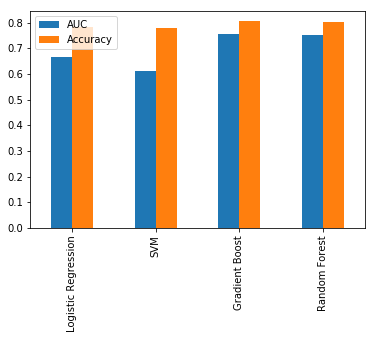

In [33]:
import pandas as pd
%matplotlib inline

rowIndex = ['Logistic Regression', 'SVM', 'Gradient Boost', 'Random Forest']
df_results = pd.DataFrame([dictLR, dictSVM, dictGBT, dictAUC], index = rowIndex)

df_results.plot(kind = 'bar')
print('    |  AUC  | Accuracy')
print('======================')
print('LR  |', "%0.3f" % lrAUC, "|", "%0.3f" % lrAccuracy)
print('SVM |', "%0.3f" % svmAUC, "|", "%0.3f" % svmAccuracy)
print('GBT |', "%0.3f" % gbtAUC, "|", "%0.3f" % gbtAccuracy)
print('RF  |', "%0.3f" % rfAUC, "|", "%0.3f" % rfAccuracy)


## Conclusion
The gradient boost classifier, a tree ensemble method, finished barely ahead of the random forest classifier. These two classifiers finished somewhat ahead of logistic regression and linear support vector machine classifiers in prediction accuracy, and far ahead in the area under ROC curve metric.

The results in this study almost as good as the results reported by the authors of [the paper that accompanied the data set](https://github.com/wangzongyan/Default-of-credit-card-clients-Data-Project/blob/master/The%20comparisons%20of%20data%20mining%20techniques%20for%20the%20predictive%20accuracy%20of%20probability%20of%20default%20of%20credit%20card%20clients.pdf). Comparisons with the original paper are uncertain, however, because the published paper does not describe any feature engineering or hyperparameter tuning by the authors.

### Future Improvements
Given more time, I would have pursued the following methods to improve the analysis:
* **Finer Hyperparameter Tuning.** The range of parameters in the parameter grids were quite wide. A finer-grained search in the vicinity of each model's best hyper-parameters, which were selected in cross-validation, would yield better predictive power.
* **More models.** 
    * Model Stack - Three methods with dissimilar errors could take a majority vote.
    * Feed-Forward Neural Network - This architecture is capable of engineering features and optimizing weights by back-propagation of training loss.
    * Recurrent Neural Network - A RNN might be able to detect sequential patterns with predictive power. 


### API Comparisons
The `pyspark.sql.DataFrame` and `pyspark.ml` APIs are quite similar to the Pandas and scikit-learn APIs, respectively. However, the standard Python libraries retain several advantages over the pyspark offerings:
1. **Greater maturity** - I occasionally found myself troubleshooting, reading source code, and tracking down bug reports to fix or work around what appeared to be pyspark defects. 
2. **Greater functionality** - The standard Python libraries often more classifiers and functionality than the pyspark offering.
3. **Better documentation** - The widespread adoption of the standard Python libraries has led to more comprehensive documentation.

In a situation where analysis can be performed on a single compute node, I would definitely choose numpy, pandas, and scikit-learn. However, the pyspark libraries are certainly good enough to turn big data into actionable insight, and can easily be justified for big data scenarios.